# 개선된 U-Net 모델 만들기

## Step 1. KITTI 데이터셋 수집과 구축

- 데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training/'

#### org Image

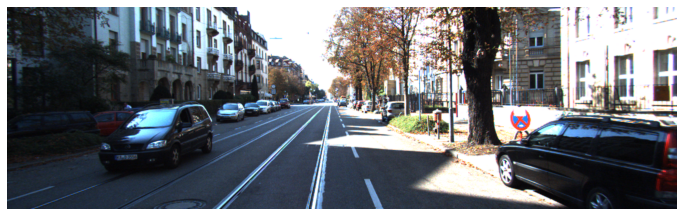

In [3]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'image_2/000000_10.png').convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

#### instance

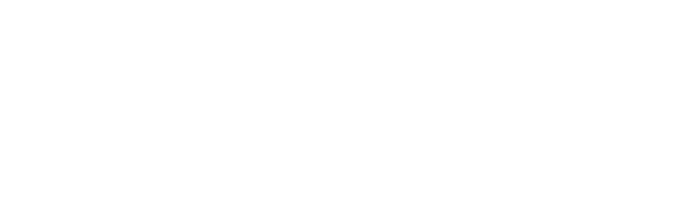

In [4]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'instance/000000_10.png')
plt.imshow(image)
plt.axis('off')
plt.show()
# 왜 출력안돼ㅜ ㅜ

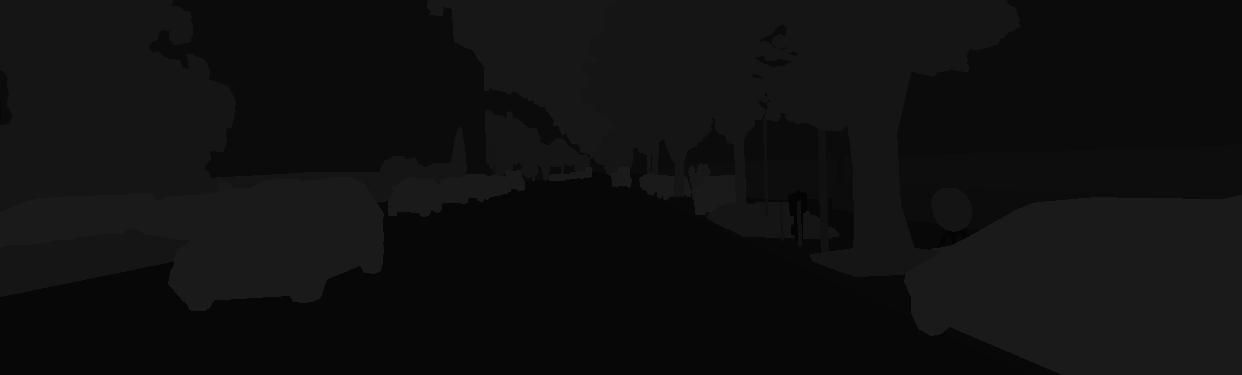

##### semantic

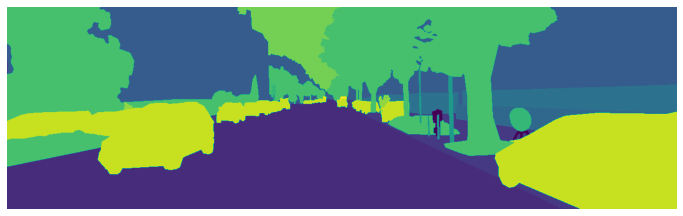

In [5]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'semantic/000000_10.png')
plt.imshow(image)
plt.axis('off')
plt.show()
# 왜 출력안돼ㅜ ㅜ

#### semantic_rgb

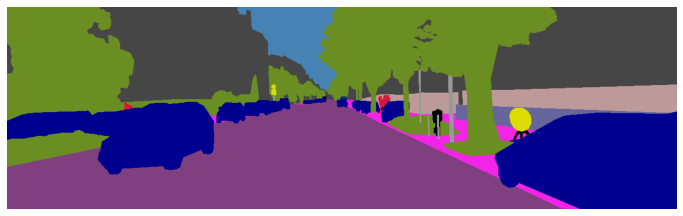

In [6]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'semantic_rgb/000000_10.png').convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

#### augmentation

In [7]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

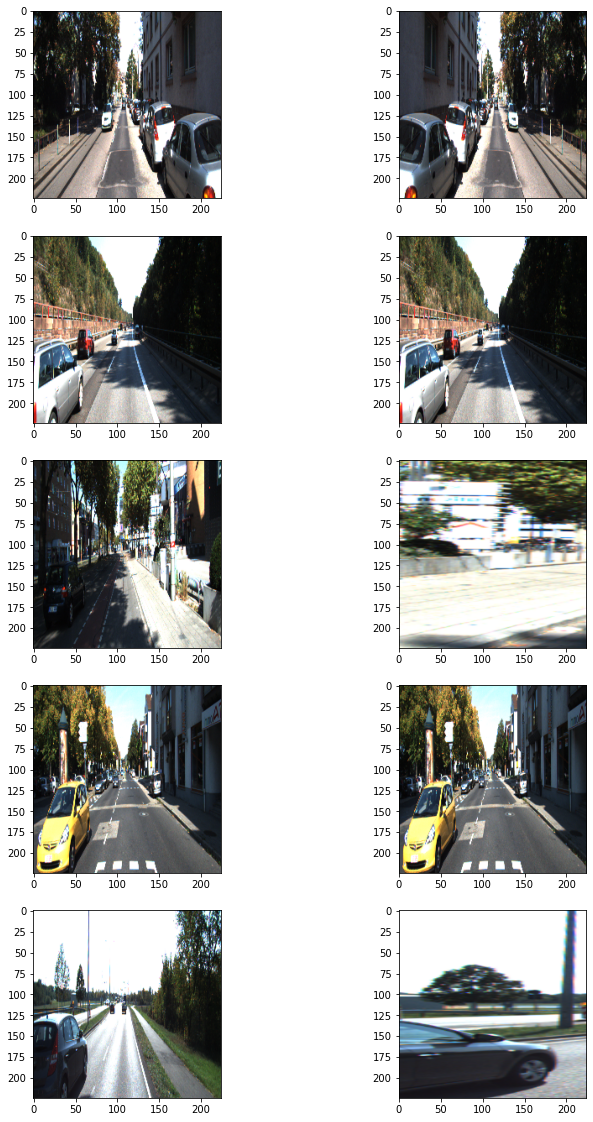

In [8]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=12,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 1 -1 U-Net으로 학습

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    # 입력 레이어
    inputs = Input(input_shape)

    # 첫 번째 Contracting Path
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 두 번째 Contracting Path
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 세 번째 Contracting Path
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 네 번째 Contracting Path
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Expanding Path
    up4 = UpSampling2D(size=(2, 2))(pool4)
    up4 = Conv2D(256, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv4, up4], axis=3)
    conv5 = conv_block(merge4, 512)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    up3 = Conv2D(128, 2, activation='relu', padding='same')(up3)
    merge3 = concatenate([conv3, up3], axis=3)
    conv6 = conv_block(merge3, 256)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv2, up2], axis=3)
    conv7 = conv_block(merge2, 128)

    up1 = UpSampling2D(size=(2, 2))(conv7)
    up1 = Conv2D(32, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv1, up1], axis=3)
    conv8 = conv_block(merge1, 64)

    # 출력 레이어
    output = Conv2D(1, 1, activation='sigmoid')(conv8)

    # 모델 생성
    model = Model(inputs=inputs, outputs=output)

    return model



# 모델 생성
input_shape = (224, 224, 3)  # 입력 이미지의 형태
num_classes = 2  # 클래스 수 (배경과 전경 등)
model = build_model(input_shape)

# 모델 컴파일
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

# model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
15/15 [==============================] - 28s 649ms/step - loss: 0.7237 - val_loss: 0.6784
Epoch 2/100
15/15 [==============================] - 9s 577ms/step - loss: 0.6786 - val_loss: 0.6600
Epoch 3/100
15/15 [==============================] - 9s 568ms/step - loss: 0.6486 - val_loss: 0.6314
Epoch 4/100
15/15 [==============================] - 8s 562ms/step - loss: 0.6396 - val_loss: 0.5979
Epoch 5/100
15/15 [==============================] - 8s 561ms/step - loss: 0.5852 - val_loss: 0.5471
Epoch 6/100
15/15 [==============================] - 8s 561ms/step - loss: 0.5155 - val_loss: 0.4851
Epoch 7/100
15/15 [==============================] - 8s 565ms/step - loss: 0.5219 - val_loss: 0.4339
Epoch 8/100
15/15 [==============================] - 9s 570ms/step - loss: 0.4863 - val_loss: 0.4061
Epoch 9/100
15/15 [==============================] - 9s 572ms/step - loss: 0.4475 - val_loss: 0.4003
Epoch 10/100
15/15 [==============================] - 9s 573ms/step - loss: 0.4342 - val_l

15/15 [==============================] - 8s 565ms/step - loss: 0.1100 - val_loss: 0.1810
Epoch 82/100
15/15 [==============================] - 8s 565ms/step - loss: 0.1187 - val_loss: 0.0786
Epoch 83/100
15/15 [==============================] - 8s 566ms/step - loss: 0.1188 - val_loss: 0.0702
Epoch 84/100
15/15 [==============================] - 8s 566ms/step - loss: 0.1049 - val_loss: 0.0508
Epoch 85/100
15/15 [==============================] - 8s 566ms/step - loss: 0.0912 - val_loss: 0.0848
Epoch 86/100
15/15 [==============================] - 8s 566ms/step - loss: 0.0965 - val_loss: 0.0525
Epoch 87/100
15/15 [==============================] - 8s 565ms/step - loss: 0.0837 - val_loss: 0.0516
Epoch 88/100
15/15 [==============================] - 8s 565ms/step - loss: 0.1064 - val_loss: 0.0543
Epoch 89/100
15/15 [==============================] - 8s 564ms/step - loss: 0.0951 - val_loss: 0.0553
Epoch 90/100
15/15 [==============================] - 8s 564ms/step - loss: 0.0867 - val_loss: 

#### Step 1 -2 U-Net 시각화

In [13]:
# model = tf.keras.models.load_model(model_path) # < 학습 진행 안할시

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [39]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / union
#     print('IoU: %f' % iou_score)
    return iou_score

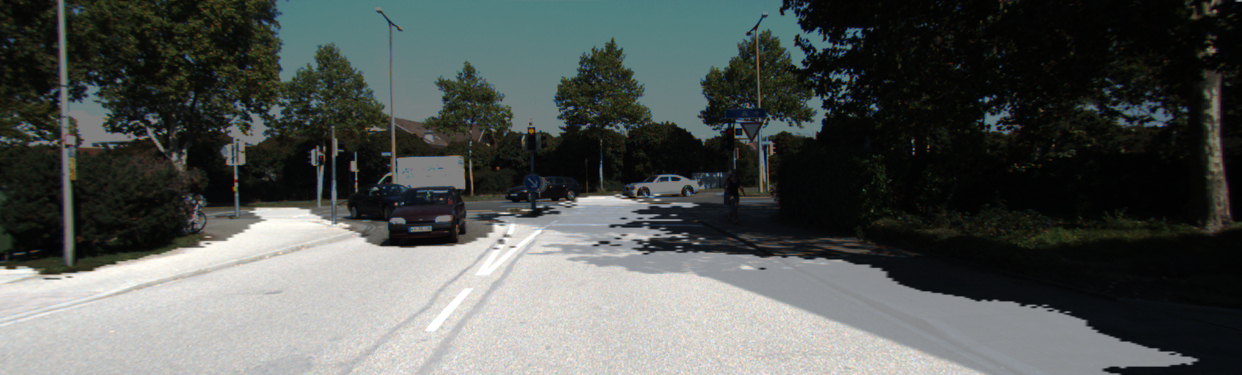

IoU: 0.749133


0.7491329479768786

In [16]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 7    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Step 2. U-Net++ 모델의 구현

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x


def UNetPlusPlus(input_shape):
    # 입력 레이어
    inputs = Input(input_shape)

    # 첫 번째 Contracting Path
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 두 번째 Contracting Path
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 세 번째 Contracting Path
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 네 번째 Contracting Path
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Expanding Path
    up4 = UpSampling2D(size=(2, 2))(pool4)
    up4 = Conv2D(256, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv4, up4], axis=3)
    conv5 = conv_block(merge4, 512)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    up3 = Conv2D(128, 2, activation='relu', padding='same')(up3)
    merge3 = concatenate([conv3, up3], axis=3)
    conv6 = conv_block(merge3, 256)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv2, up2], axis=3)
    conv7 = conv_block(merge2, 128)

    up1 = UpSampling2D(size=(2, 2))(conv7)
    up1 = Conv2D(32, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv1, up1], axis=3)
    conv8 = conv_block(merge1, 64)

    # 출력 레이어
    output = Conv2D(1, 1, activation='sigmoid')(conv8)

    # 모델 생성
    model = Model(inputs=inputs, outputs=output)
    
    return model

# 모델 생성
input_shape = (224, 224, 3)  # 입력 이미지의 형태
num_classes = 2  # 클래스 수 (배경과 전경 등)
pp_model = UNetPlusPlus(input_shape)

# 모델 컴파일
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
pp_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 224, 224, 64) 256         conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 224, 224, 64) 36928       batch_normalization_32[0][0]     
____________________________________________________________________________________________

In [21]:
pp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

# pp_model = build_model_UNetpp()
pp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
pp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

pp_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
15/15 [==============================] - 11s 607ms/step - loss: 0.7168 - val_loss: 0.6970
Epoch 2/100
15/15 [==============================] - 9s 587ms/step - loss: 0.6683 - val_loss: 0.6972
Epoch 3/100
15/15 [==============================] - 9s 586ms/step - loss: 0.6479 - val_loss: 0.6957
Epoch 4/100
15/15 [==============================] - 9s 574ms/step - loss: 0.6450 - val_loss: 0.6779
Epoch 5/100
15/15 [==============================] - 9s 569ms/step - loss: 0.6196 - val_loss: 0.6733
Epoch 6/100
15/15 [==============================] - 8s 563ms/step - loss: 0.6137 - val_loss: 0.6447
Epoch 7/100
15/15 [==============================] - 8s 561ms/step - loss: 0.5781 - val_loss: 0.6233
Epoch 8/100
15/15 [==============================] - 8s 561ms/step - loss: 0.5842 - val_loss: 0.6014
Epoch 9/100
15/15 [==============================] - 8s 564ms/step - loss: 0.5481 - val_loss: 0.5894
Epoch 10/100
15/15 [==============================] - 8s 565ms/step - loss: 0.5536 - val_l

15/15 [==============================] - 8s 565ms/step - loss: 0.1302 - val_loss: 0.1969
Epoch 82/100
15/15 [==============================] - 8s 566ms/step - loss: 0.1636 - val_loss: 0.1859
Epoch 83/100
15/15 [==============================] - 8s 565ms/step - loss: 0.1128 - val_loss: 1.1923
Epoch 84/100
15/15 [==============================] - 8s 567ms/step - loss: 0.1384 - val_loss: 1.2005
Epoch 85/100
15/15 [==============================] - 8s 565ms/step - loss: 0.1227 - val_loss: 1.3071
Epoch 86/100
15/15 [==============================] - 9s 567ms/step - loss: 0.1161 - val_loss: 1.1729
Epoch 87/100
15/15 [==============================] - 8s 564ms/step - loss: 0.0953 - val_loss: 1.2482
Epoch 88/100
15/15 [==============================] - 8s 565ms/step - loss: 0.0986 - val_loss: 1.4985
Epoch 89/100
15/15 [==============================] - 8s 566ms/step - loss: 0.1173 - val_loss: 0.4882
Epoch 90/100
15/15 [==============================] - 8s 565ms/step - loss: 0.1068 - val_loss: 

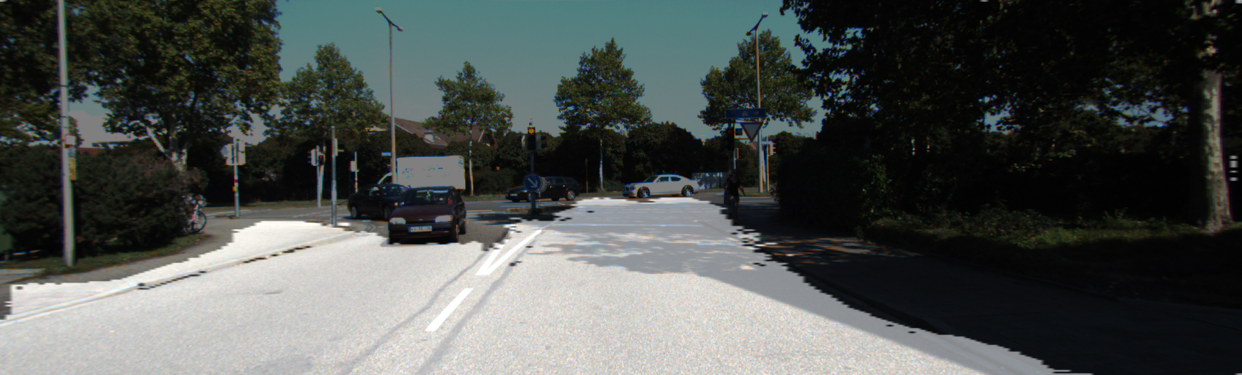

IoU: 0.861654


0.8616540256709452

In [22]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 7    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     pp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./pp_result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [34]:
def get_iou(unet, unetpp, preproc, image_path, label_path, view_on):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = unet(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5) # 이미지 합성
    
    data_pp = {"image":origin_img}
    processed = preproc(**data_pp)
    outputpp = unetpp(np.expand_dims(processed["image"]/255,axis=0))
    outputpp = (outputpp[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction_pp = outputpp/255   # 도로로 판단한 영역
    
    outputpp = Image.fromarray(outputpp)
    background = Image.fromarray(origin_img).convert('RGBA')
    outputpp = outputpp.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    outputpp = Image.blend(background, outputpp, alpha=0.5) # 이미지 합성
    if view_on:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) # 2 x 1 이미지 틀 생성
        ax1.imshow(output) # img 설정
        ax1.axis('off') # 축 제거
        ax1.set_title('unet') # title 설정

        ax2.imshow(outputpp) # img 설정
        ax2.axis('off') # 축 제거
        ax2.set_title('unet++') # title 설정

        plt.tight_layout()
        plt.show()
        
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        unet_iou = calculate_iou_score(target, prediction)
        unetpp_iou = calculate_iou_score(target, prediction_pp)
        
        return unet_iou, unetpp_iou
    else:
        return _, _

###### Test Datasets 확인

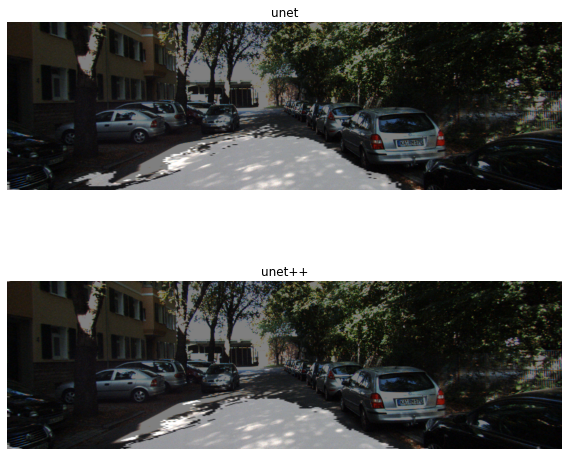

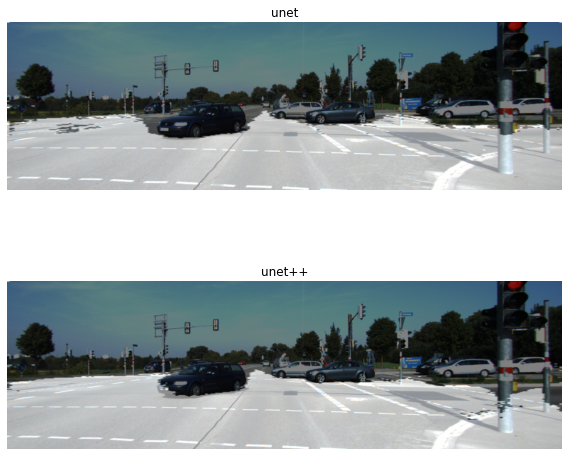

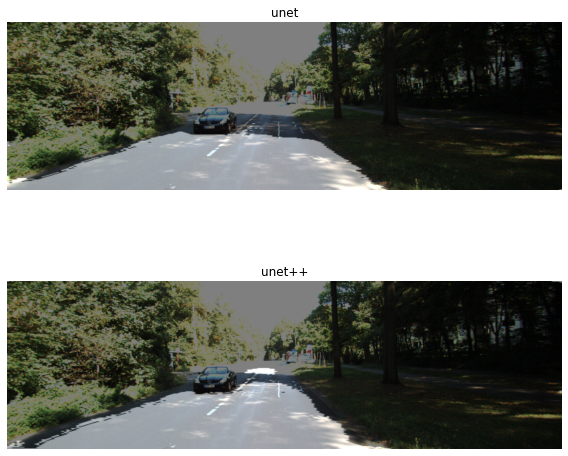

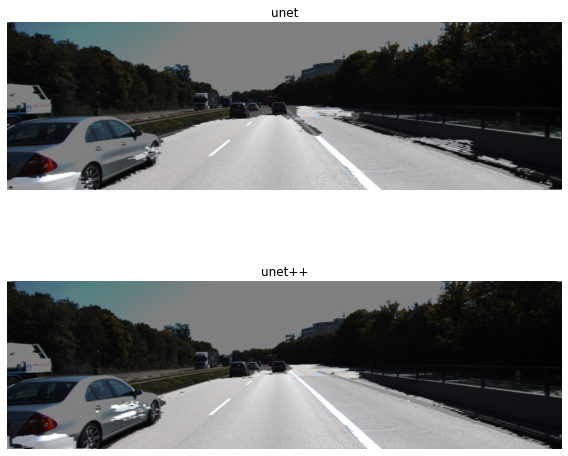

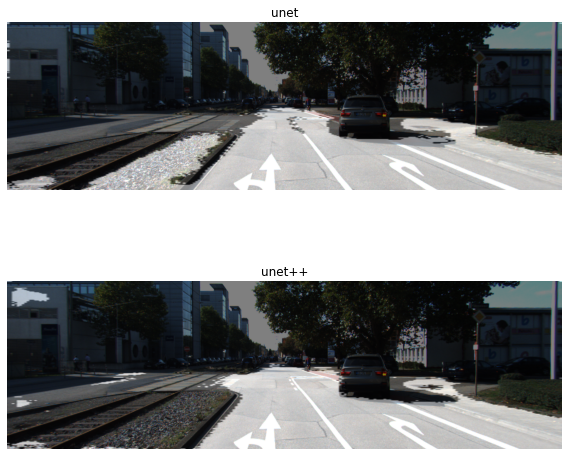

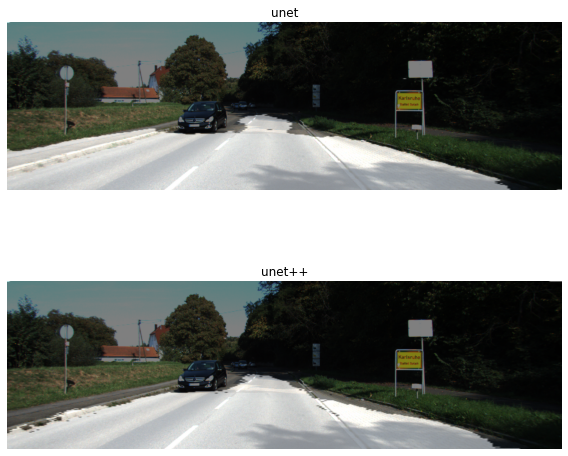

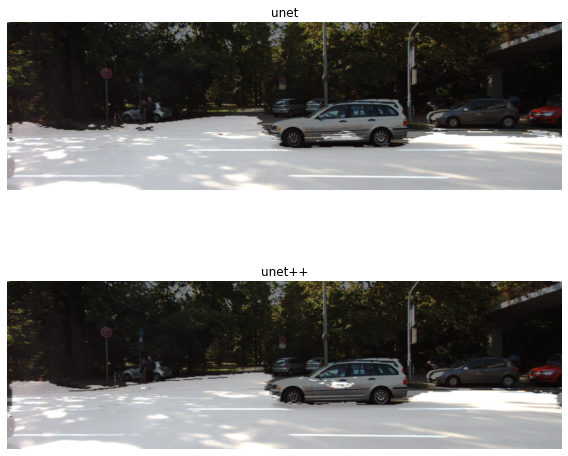

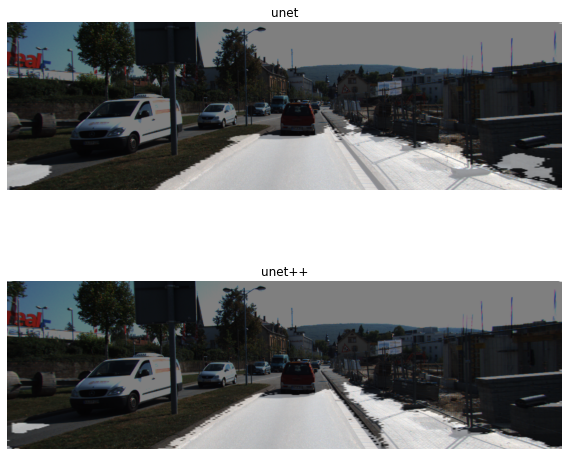

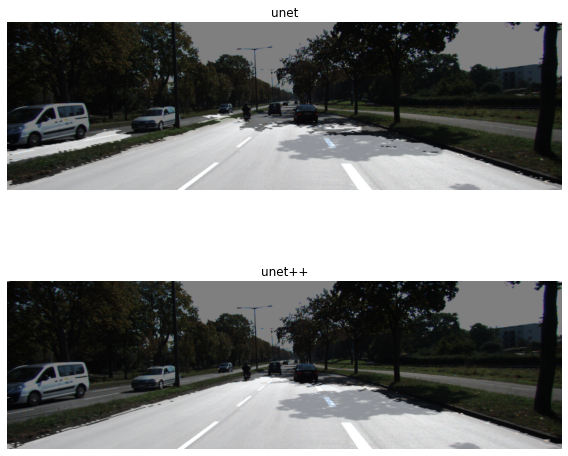

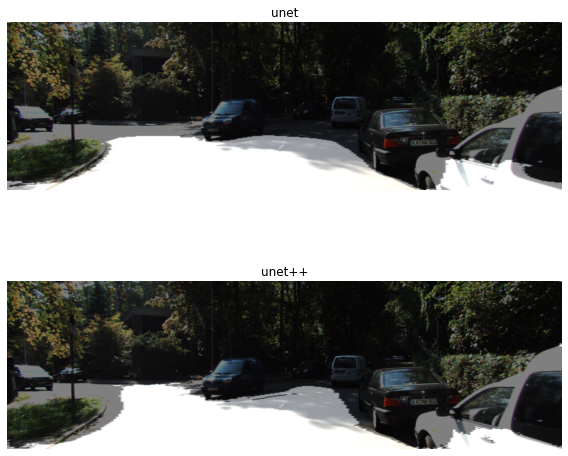

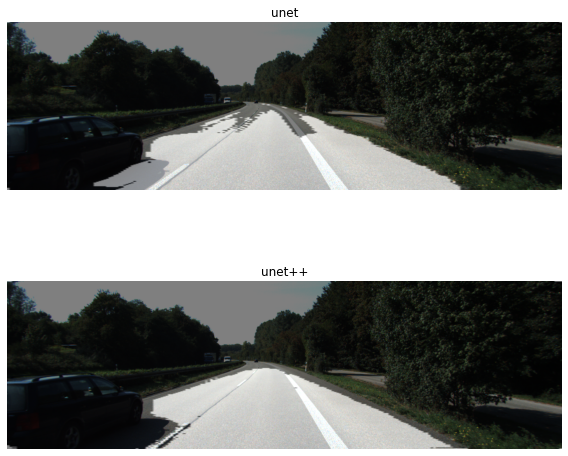

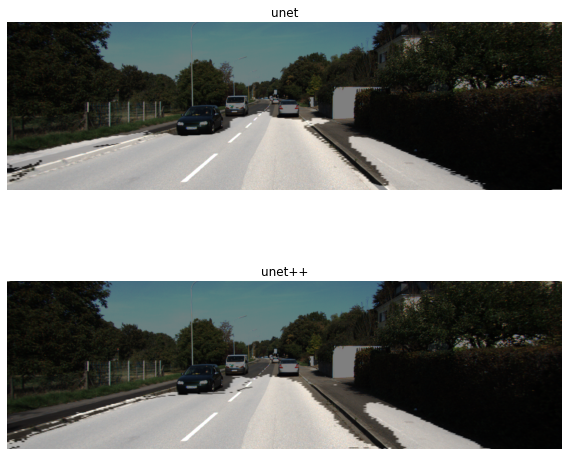

In [36]:
import random
test_dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/testing/image_2/'
test_folder = os.listdir(test_dir_path)
view_array = [False] * len(test_folder)  # test_folder의 image수 만큼을 False로 초기화한 배열#

# 12개의 요소를 랜덤하게 True로 설정
random_indices = random.sample(range(len(view_array)), 12)
view_array = [True if i in random_indices else False for i in range(len(view_array))]

for i, image_name in enumerate(test_folder):
    _, _ = get_iou(
    model,
    pp_model,
    test_preproc,
    image_path=test_dir_path + image_name,
    label_path=False,
    view_on=view_array[i]
    )

In [40]:
unet_ioues = []
unetpp_ioues = []
train_folder = dir_path + '/image_2/'
for i, _ in enumerate(os.listdir(train_folder)):
    unet_iou, unetpp_iou = get_iou(
        model,
        pp_model,
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
        view_on=False
     )
    unet_ioues.append(unet_iou)
    unetpp_ioues.append(unetpp_iou)


In [47]:
def calculate_ap(iou_list, iou_threshold=0.5):
    # True Positive(TP) 및 False Positive(FP) 초기화
    tp = [0] * len(iou_list)
    fp = [0] * len(iou_list)

    # 실제 상자 수
    num_gt_boxes = len(iou_list)

    # 각 예측 상자에 대한 IoU 계산
    for i, iou in enumerate(iou_list):
        if iou >= iou_threshold:
            tp[i] = 1
        else:
            fp[i] = 1

    # Precision과 Recall 계산
    cumulative_tp = np.cumsum(tp)
    cumulative_fp = np.cumsum(fp)
    precision = cumulative_tp / (cumulative_tp + cumulative_fp)
    recall = cumulative_tp / num_gt_boxes

    # AP50 계산
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11

    return ap

In [55]:
unet_ap_50 = calculate_ap(unet_ioues, iou_threshold=0.5)
unet_ap_50

0.7819733138725037

In [56]:
unet_ap_70 = calculate_ap(unet_ioues, iou_threshold=0.7)
unet_ap_70

0.4891839706988954

In [57]:
unet_ap_90 = calculate_ap(unet_ioues, iou_threshold=0.9)
unet_ap_90

0.0019240019240019239

In [58]:
unetpp_ap_50 = calculate_ap(unetpp_ioues, iou_threshold=0.5)
unetpp_ap_50

0.7719520710976205

In [59]:
unetpp_ap_70 = calculate_ap(unetpp_ioues, iou_threshold=0.7)
unetpp_ap_70

0.49534563606437326

In [60]:
unetpp_ap_90 = calculate_ap(unetpp_ioues, iou_threshold=0.9)
unetpp_ap_90

0.05628827131417805

|Net|Ap50|Ap70|Ap90|
|---|----|----|----|
|UNet|0.782|0.489|0.002|
|UNetpp|0.772|0.495|0.056|

왜 인지...
Ap50에서는 UNet이 좋았지만
그 외에는 Unetpp가 이겼습니다..

gpt의 unet이 잘못된 느낌... pram은 왜 같지...